In [153]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

def evaluate_model(best_model, data_test):
    # Avaliação do modelo no conjunto de teste
    loss, accuracy = best_model.evaluate(data_test)
    print(f"Avaliação no conjunto de teste:\nLoss: {loss}\nAccuracy: {accuracy}")
    return loss, accuracy

def plot_confusion_matrix(best_model, data_test, class_names):
    # Obter rótulos verdadeiros e previstos
    y_true = np.concatenate([y for x, y in data_test], axis=0)
    y_pred = tf.argmax(best_model.predict(data_test), axis=1)

    # Matriz de confusão
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plotar
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Matriz de Confusão")
    plt.show()

def classification_report_model(best_model, data_test, class_names):
    # Obter rótulos verdadeiros e previstos
    y_true = np.concatenate([y for x, y in data_test], axis=0)
    y_pred = tf.argmax(best_model.predict(data_test), axis=1)

    # Relatório de classificação
    report = classification_report(y_true, y_pred, target_names=class_names)
    print(f"Relatório de Classificação:\n{report}")



- **Seaborn**, biblioteca em python foi utilizada para gerar gráfico de comparação da acurácia ao longo das epochs.
- **Scikit-learn**, para clasular métricas de avaliação.
  - confusion_matrix: Matriz de confusão para análise de desempenho.
  - classification_report: Relatório com precisão, recall e F1-score.
- **Tensor-flow**, para o carregamento e tratamento dos dados utilizados na modelagem e para a criação, treinamento e avaliação de modelo de classificação.
- **Numpy**, para conversão de imagens em array multidimensionais.
- **TensorFlow**, para construção e treinamento de modelos de deep learning.
- **Keras** (tensorflow.keras), API de alto nível para redes neurais (integradas ao TensorFlow).
  - Sequential: Modelo sequencial para empilhar camadas.
  - layers: Camadas pré-definidas (ex: Conv2D, MaxPooling2D, Dense).
  - ImageDataGenerator: Pré-processamento e aumento de dados para imagens.

In [154]:
import pandas as pd
import seaborn as sns
import sklearn as sk
import numpy as np
import tensorflow as tf
import zipfile
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import os


In [173]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import os

# Configurações iniciais
# O caminho para os diretórios de treinamento e teste são armazenados nas seguintes variáveis:
train_path = "/home/adsr/Documentos/cjovem/Uece-C-Jovem/Ciência de Dados - Avançado/aux/360fruits/teste"
test_path = "/home/adsr/Documentos/cjovem/Uece-C-Jovem/Ciência de Dados - Avançado/aux/360fruits/treinamento"
img_size = (150, 150)
batch_size = 32
num_classes = 3
epochs = 50

# Geradores de dados com aumento e normalização
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

# Cálculo de pesos das classes
class_weights = {0: 1.0, 1: 4569/1430, 2: 4569/1181}

# Modelo aprimorado com MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(150, 150, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compilação com hiperparâmetros ajustados
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
]

# Treinamento
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks
)

# Avaliação
test_loss, test_acc = model.evaluate(test_generator)
print(f"Acurácia no teste: {test_acc:.4f}")

# Matriz de confusão e relatório
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.labels

class_names = list(train_generator.class_indices.keys())

print("\nRelatório de Classificação:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

Found 5745 images belonging to 3 classes.
Found 1435 images belonging to 3 classes.
Found 3403 images belonging to 3 classes.


/tmp/ipykernel_61923/2476317911.py:62: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/home/adsr/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 95s 501ms/step - accuracy: 0.6883 - loss: 1.8371 - val_accuracy: 0.9575 - val_loss: 0.5538 - learning_rate: 1.0000e-04
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 135s 462ms/step - accuracy: 0.9542 - loss: 0.6669 - val_accuracy: 0.9596 - val_loss: 0.5270 - learning_rate: 1.0000e-04
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 88s 488ms/step - accuracy: 0.9734 - loss: 0.5697 - val_accuracy: 0.9756 - val_loss: 0.4733 - learning_rate: 1.0000e-04
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 91s 505ms/step - accuracy: 0.9787 - loss: 0.5078 - val_accuracy: 0.9735 - val_loss: 0.4755 - learning_rate: 1.0000e-04
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 153s 567ms/step - accuracy: 0.9810 - loss: 0.4786 - val_accuracy: 0.9672 - val_loss: 0.4665 - learning_rate: 1.0000e-04
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 118s 653ms/step - accuracy: 0.9870 - loss: 0.4502 - val_accuracy: 0.9861 - val_loss: 0.4103 - learning_rate: 1.0000e-04
Epoch 7/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 81s

KeyboardInterrupt: 

In [155]:
# O caminho para os diretórios de treinamento e teste são armazenados nas seguintes variáveis:
train_path = "/home/adsr/Documentos/cjovem/Uece-C-Jovem/Ciência de Dados - Avançado/aux/360fruits/teste"
test_path = "/home/adsr/Documentos/cjovem/Uece-C-Jovem/Ciência de Dados - Avançado/aux/360fruits/treinamento"

In [156]:
def count_images_in_directory(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len(files)
    return count

train_count = count_images_in_directory(train_path)
test_count = count_images_in_directory(test_path)

print(f"Quantidade de imagem para Treinamento e Validação: {train_count}")
print(f"Quantidade de imagens para Teste: {test_count} \n")

# Calculate and display metrics for each subdirectory
def calculate_metrics(directory):
    metrics = {}
    if os.path.exists(directory):
        for subdir in os.listdir(directory):
            subdir_path = os.path.join(directory, subdir)
            if os.path.isdir(subdir_path):
                metrics[subdir] = count_images_in_directory(subdir_path)
    return metrics

train_metrics = calculate_metrics(train_path)
test_metrics = calculate_metrics(test_path)

print("Quantidade de imagens para Treinamento e Validação por fruta:")
for fruit, count in train_metrics.items():
    print(f"{fruit}: {count} images")
print("\n")
print("Quantidade de imagens para Teste por fruta:")
for fruit, count in test_metrics.items():
    print(f"{fruit}: {count} images")

Quantidade de imagem para Treinamento e Validação: 7180
Quantidade de imagens para Teste: 3403 

Quantidade de imagens para Treinamento e Validação por fruta:
Banana: 1430 images
Apple: 4569 images
Orange: 1181 images


Quantidade de imagens para Teste por fruta:
Banana: 484 images
Apple: 2525 images
Orange: 394 images


**Mostra das imagens que estão no diretório e sua respectivas classes:**

Found 7180 files belonging to 3 classes.


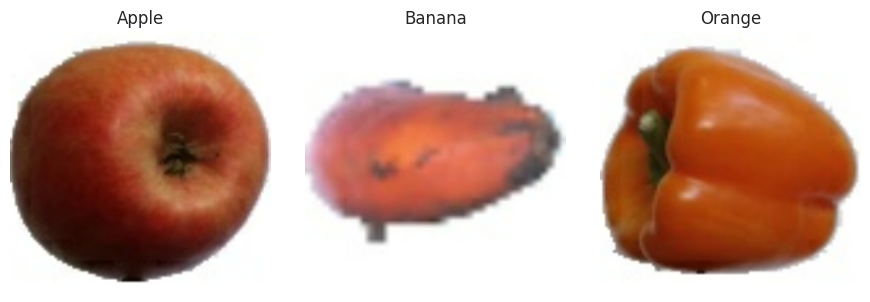

In [157]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    labels="inferred"
)

class_names = train_data.class_names
num_classes = len(class_names)
samples = [None] * num_classes

for images, labels in train_data:
    for img, lbl in zip(images, labels):
        lbl_idx = lbl.numpy()
        if samples[lbl_idx] is None:
            samples[lbl_idx] = img
    if all(sample is not None for sample in samples):
        break

fig, axes = plt.subplots(1, num_classes, figsize=(num_classes * 3, 3))

for i in range(num_classes):
    axes[i].imshow(samples[i].numpy().astype("uint8"))
    axes[i].set_title(class_names[i])
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [158]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Cria um gerador de dados para treinamento com aumento de dados
train_datagen = ImageDataGenerator(
    rotation_range=20,  # Rotação aleatória
    width_shift_range=0.2,  # Deslocamento horizontal
    height_shift_range=0.2,  # Deslocamento vertical
    shear_range=0.2,  # Transformação (corte) na imagem
    zoom_range=0.2,  # Zoom aleatório
    horizontal_flip=True,  # Inversão horizontal
    fill_mode='nearest',  # Como preencher novos pixels criados pela rotação/deslocamento
    validation_split=0.2  # Reservar parte das imagens para validação
)

# Cria um gerador de dados para a validação (sem aumentar dados, geralmente)
val_datagen = ImageDataGenerator(
    validation_split=0.2
)

# Esses caminhos devem apontar para o diretório de treinamento
# com subpastas para cada classe
train_path = "/home/adsr/Documentos/cjovem/Uece-C-Jovem/Ciência de Dados - Avançado/aux/360fruits/teste"

# Gera lotes de dados de treinamento
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(100,100),  # Tamanho padronizado das imagens
    batch_size=32,
    class_mode='sparse',
    subset='training'
    # Subconjunto de treinamento
)

# Gera lotes de dados de validação
val_generator = val_datagen.flow_from_directory(
    train_path,
    target_size=(100, 100),  # Tamanho padronizado das imagens
    batch_size=32,
    class_mode='sparse',
    subset='validation'  # Subconjunto de validação
)



Found 5745 images belonging to 3 classes.
Found 1435 images belonging to 3 classes.


In [159]:
img_widht = 100
img_height = 100


In [160]:
dataset_params = {
    "labels": "inferred",
    "label_mode": "int",
    "image_size": (img_widht, img_height),
    "color_mode": "rgb",
    "batch_size": 32,
    "shuffle": True,
    "seed": 42
}

In [161]:

class_names = data_train.class_names

data_test = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    **dataset_params,
    
    
)



Found 3403 files belonging to 3 classes.


In [162]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import Dropout

model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax'),

])
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))


model.add(Dropout(0.5))




In [163]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [164]:
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau,
    TensorBoard,
    CSVLogger
)
import datetime
import os

# Criar diretório para salvar logs e checkpoints se não existir
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_dir = "checkpoints"
os.makedirs(log_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)

# 1. ModelCheckpoint - Salva o melhor modelo durante o treinamento
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'model_best.h5'),
    monitor='val_accuracy',  # métrica para monitorar
    mode='max',  # queremos maximizar a acurácia
    save_best_only=True,  # salva apenas o melhor modelo
    verbose=1
)

# 2. EarlyStopping - Para o treinamento se não houver melhoria
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,  # número de épocas para aguardar melhoria
    restore_best_weights=True,
    verbose=1
)

# 3. ReduceLROnPlateau - Reduz a taxa de aprendizado quando as métricas estagnam
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # fator de redução da taxa de aprendizado
    patience=3,  # número de épocas para aguardar melhoria
    min_lr=1e-6,  # menor taxa de aprendizado permitida
    verbose=1
)

# 4. TensorBoard - Para visualização do treinamento em tempo real
tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,  # frequência de cálculo dos histogramas
    write_graph=True,
    write_images=True,
    update_freq='epoch'
)

# 5. CSVLogger - Salva as métricas em um arquivo CSV
csv_logger = CSVLogger(
    'training_log.csv',
    separator=',',
    append=False  # se False, sobrescreve o arquivo existente
)

# Lista com todos os callbacks
callbacks = [
    checkpoint_callback,
    early_stopping,
    reduce_lr,
    tensorboard_callback,
    csv_logger
]



In [165]:
history = model.fit(
    train_generator,  # Imagens de treinamento e rótulos de treinamento incluídos no tf.data.Dataset
    epochs=5,  # Número de épocas
    validation_data=val_generator,  # Dados de validação
    batch_size=32,
    callbacks=callbacks
)

/home/adsr/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.2475 - loss: 9.3171
Epoch 1: val_accuracy improved from -inf to 0.63624, saving model to checkpoints/model_best.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 54s 290ms/step - accuracy: 0.2486 - loss: 9.3059 - val_accuracy: 0.6362 - val_loss: 6.2422 - learning_rate: 0.0010
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.5823 - loss: 6.2422
Epoch 2: val_accuracy did not improve from 0.63624
180/180 ━━━━━━━━━━━━━━━━━━━━ 40s 220ms/step - accuracy: 0.5822 - loss: 6.2422 - val_accuracy: 0.6362 - val_loss: 6.2398 - learning_rate: 0.0010
Epoch 3/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.5727 - loss: 6.2397
Epoch 3: val_accuracy did not improve from 0.63624
180/180 ━━━━━━━━━━━━━━━━━━━━ 44s 246ms/step - accuracy: 0.5729 - loss: 6.2397 - val_accuracy: 0.6362 - val_loss: 6.2394 - learning_rate: 0.0010
Epoch 4/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.6462 - loss: 6.2394
Epoch 4: val_accuracy did not improve from 0.63624
180/180 ━━━━━━━━━━━━━━━━━━━━ 43s 240ms/step - accuracy: 0.6461 - loss: 6.2394 - val_accuracy: 0.6362 - val_loss: 6.2393 - learning_rate: 0.0010
Epoch 5/5


In [169]:
best_model = tf.keras.models.load_model(os.path.join(checkpoint_dir, 'model_best.h5'))

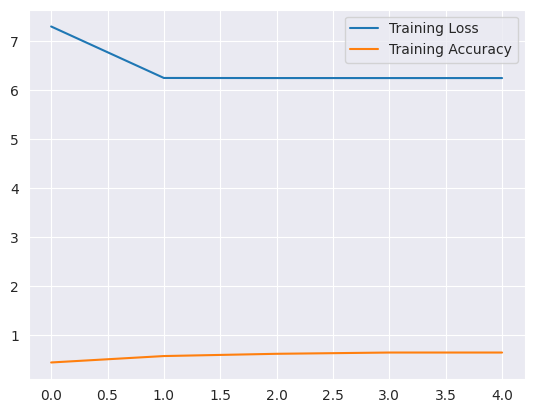

In [170]:
accuracy, loss = history.history['accuracy'], history.history['loss']
val_accuracy, val_loss = history.history['val_accuracy'], history.history['val_loss']

plt.plot(loss, label="Training Loss")
plt.plot(accuracy, label="Training Accuracy")

plt.legend()

107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step

Relatório de classificação:
              precision    recall  f1-score   support

       Apple       0.74      1.00      0.85      2525
      Banana       0.00      0.00      0.00       484
      Orange       0.00      0.00      0.00       394

    accuracy                           0.74      3403
   macro avg       0.25      0.33      0.28      3403
weighted avg       0.55      0.74      0.63      3403



/home/adsr/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/adsr/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/adsr/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


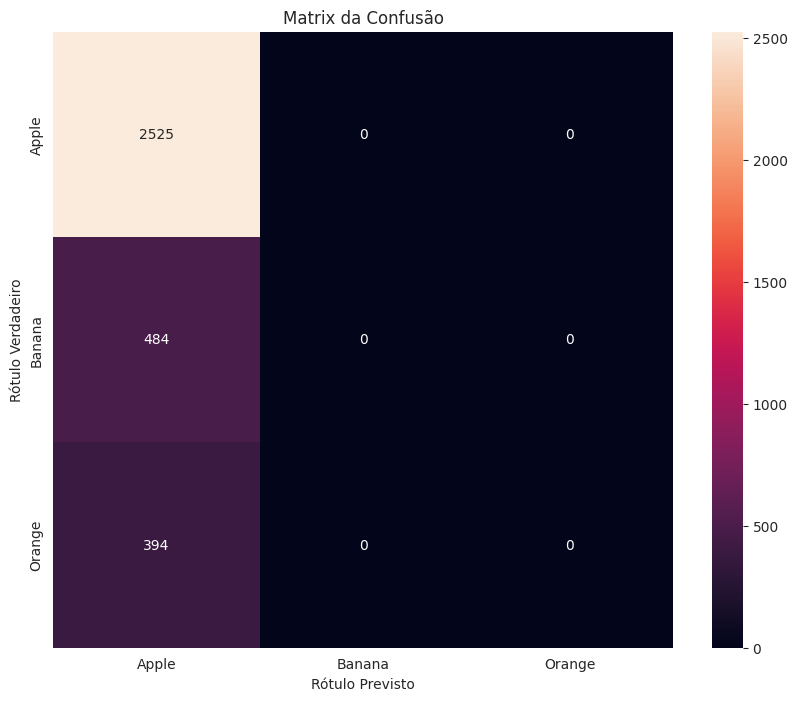

In [171]:


y_pred = best_model.predict(data_test)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.concatenate([y for x, y in data_test], axis=0)

class_names = ["Apple", "Banana", "Orange"]
print("\nRelatório de classificação:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Matrix da Confusão")
plt.ylabel("Rótulo Verdadeiro")
plt.xlabel("Rótulo Previsto")
plt.show()
##